In [15]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer,OneHotEncoder,OrdinalEncoder
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,Lasso
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import StackingRegressor



from xgboost import XGBRegressor


In [39]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
train_df = pd.read_csv('train.csv',index_col=0)
test_df = pd.read_csv('test.csv',index_col=0)


X_train = train_df.drop('SalePrice', axis=1)
y_train = train_df['SalePrice']

X_test=test_df

X_train.describe()

print(X_train.isnull().sum())

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 79, dtype: int64


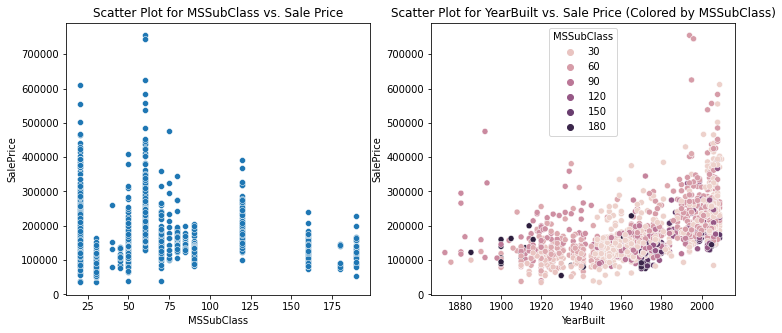

In [17]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=X_train['MSSubClass'], y=y_train, ax=axes[0])
axes[0].set_title("Scatter Plot for MSSubClass vs. Sale Price")

sns.scatterplot(x=X_train['YearBuilt'], y=y_train, hue=X_train['MSSubClass'], ax=axes[1])
axes[1].set_title("Scatter Plot for YearBuilt vs. Sale Price (Colored by MSSubClass)")
plt.show()


In [18]:
numerical_cols=X_train.select_dtypes(exclude=['object'])
categorical_cols=X_train.select_dtypes(include=['object'])
cols_with_missing_values=[cols for cols in X_train.columns if X_train[cols].isnull().sum().any()]
print(cols_with_missing_values)


['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [19]:
ordinal_encoder=OrdinalEncoder()
hot_encoder=OneHotEncoder(handle_unknown='ignore')

numerical_imputer=SimpleImputer(strategy='mean')
categorical_imputer=SimpleImputer(strategy='most_frequent')

standard_scaler=StandardScaler()
min_max_scaler=MinMaxScaler()
power_transformer=PowerTransformer()


In [20]:
X_drop=X_train.copy()
dropping=X_drop.dropna(axis=1)

my_pipeline0=Pipeline(steps=[
    ('droppin_null',dropping),
    ('ordinal_encoder',ordinal_encoder)
])

In [21]:
my_pipeline1=Pipeline(steps=[
    ('numerical_imputer',numerical_imputer),
    ('standard_scaler',standard_scaler)  
])

numerical_data_standard=my_pipeline1.fit_transform(numerical_cols)

In [22]:
my_pipeline2=Pipeline(steps=[
    ('numerical_imputer',numerical_imputer),
    ('min_max_scaler',min_max_scaler)
])

numerical_data_min_max=my_pipeline2.fit_transform(numerical_cols)

In [23]:
my_pipeline3=Pipeline(steps=[
    ('numerical_imputer',numerical_imputer),
    ('power_transformer',power_transformer)   
])

numerical_data_transformer=my_pipeline3.fit_transform(numerical_cols)

/home/jude/.local/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [24]:
my_pipeline4=Pipeline(steps=[
    ('categorical_imputer',categorical_imputer),
    ('ordinal_encoder',ordinal_encoder)
    ])
categorical_ordinal=my_pipeline4.fit_transform(categorical_cols)

In [27]:
my_pipeline5=Pipeline(steps=[
    ('categorical_imputer',categorical_imputer),
    ('one_hot_encoder',hot_encoder)
])

categorical_one_hot=my_pipeline5.fit_transform(categorical_cols)

In [ ]:
class CustomEncoder(BaseEstimator,TransformerMixin):
    
    def __init__(self,threshold=10):
        self.threshold=threshold
        self.one_hot_cols=[]
        self.ordinal_cols=[]
        
    def fit(self,X, y=None):
        for col in X.columns:
            if X[col].nunique()<self.threshold:
                self.one_hot_cols.append(col)
            else:
                self.ordinal_cols.append(col)
        return self
    
    def transform(self,X,y=None):
        one_hot_encoder=OneHotEncoder(handle_unknown='ignore')
        ordinal_encoder=OneHotEncoder()
        
        one_hot_encoded=one_hot_encoder.fit_transform(X[self.one_hot_cols])
        ordinal_encoded=ordinal_encoder.fit_transform(X[self.ordinal_cols])
        
        one_hot_df=pd.DataFrame(one_hot_encoded.toarray(),columns=self.one_hot_cols)
        ordinal_df=pd.DataFrame(ordinal_encoded,columns=self.ordinal_cols)
        
        return pd.concat([one_hot_df,ordinal_df],axis=1)
    
categorical_cols_df = pd.DataFrame(categorical_cols, columns=categorical_cols.columns)

my_pipeline6 = Pipeline(steps=[
    ('categorical_imputer', categorical_imputer),
    ('custom_encoder', CustomEncoder(threshold=10))
])

categorical_ordinal_one_hot = my_pipeline6.fit_transform(categorical_cols_df)


In [28]:
def series_to_df(array):
    return pd.DataFrame(array)

numerical_standard_df=series_to_df(numerical_data_standard)
numerical_data_min_max_df=series_to_df(numerical_data_min_max)
categorical_ordinal_df=series_to_df(categorical_ordinal)
numerical_pow_df=series_to_df(numerical_data_transformer)
categorical_hot_df=series_to_df(categorical_one_hot)


def join_dataframes(num_df,cat_df):
    new_df=pd.concat([num_df,cat_df],axis=1)
    return new_df

cat_ordinal_num_standard=join_dataframes(numerical_standard_df,categorical_ordinal_df)
cat_ordinal_min_max=join_dataframes(numerical_data_min_max_df,categorical_ordinal_df)
cat_ordinal_num_power=join_dataframes(numerical_pow_df,categorical_ordinal_df)

cat_hot_num_standard=join_dataframes(numerical_standard_df,categorical_hot_df)
cat_hot_min_max=join_dataframes(numerical_data_min_max_df,categorical_hot_df)
cat_hot_num_power=join_dataframes(numerical_pow_df,categorical_hot_df)


In [ ]:
def fit_pca(X_train,n_components=15):
    pca=PCA(n_components=n_components)

    pca.fit(X_train)
    X_train_reduced=pca.transform(X_train)
    #X_test_reduced=pca.transform(X_test)
    
    return X_train_reduced
cat_hot_num_power_dense = cat_hot_num_power.values
cat_hot_num_power_reduced=fit_pca(cat_hot_num_power_dense,n_components=15)
cat_hot_num_power_dense

In [41]:
def rand_forest_mod(X_train,y_train):
    model=RandomForestRegressor(random_state=0)
    param_grid={
        'n_estimators':[i for i in range(50,300,50)],
        'criterion':['mse','mae'],
        'bootstrap':[True,False],
        'max_features':['auto','log2','sqrt','None']
        
    }
    
    search_cv=GridSearchCV(model,param_grid,cv=5)
    search_cv.fit(X_train,y_train)
    best_params = search_cv.best_params_
    best_model = search_cv.best_estimator_
    best_score=search_cv.best_score_
    
    return best_model,best_params,best_score
best_model, best_params, best_score = rand_forest_mod(cat_ordinal_num_standard, y_train)

print("Best Model:")
print(best_model)

print("\nBest Hyperparameters:")
print(best_params)

print("\nBest Score:")
print(best_score)

    

Best Model:
RandomForestRegressor(bootstrap=False, criterion='mse', max_features='sqrt',
                      n_estimators=150, random_state=0)

Best Hyperparameters:
{'bootstrap': False, 'criterion': 'mse', 'max_features': 'sqrt', 'n_estimators': 150}

Best Score:
0.8802443597011795


In [43]:
def xgb_reg(X_train,y_train):
    model=XGBRegressor()
    
    param_grid = {
    'n_estimators': [i for i in range(100,1000,80)],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01,0.05,0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_param=grid_search.best_params_
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    
    return best_estimator,best_param,best_score

def resolve_duplicate_feature_names(X_train):
    X_train = X_train.copy()  
    seen_names = set()
    new_feature_names = []
    for feature_name in X_train.columns:
        if feature_name in seen_names:
            i = 1
            new_feature_name = f"{feature_name}_{i}"
            while new_feature_name in seen_names:
                i += 1
                new_feature_name = f"{feature_name}_{i}"
            seen_names.add(new_feature_name)
            new_feature_names.append(new_feature_name)
        else:
            seen_names.add(feature_name)
            new_feature_names.append(feature_name)
    X_train.columns = new_feature_names
    return X_train

cat_ordinal_num_standard = resolve_duplicate_feature_names(cat_ordinal_num_standard)

best_model, best_params, best_score = xgb_reg(cat_ordinal_num_standard, y_train)

print("Best Model:")
print(best_model)

print("\nBest Hyperparameters:")
print(best_params)

print("\nBest Score:")
print(best_score)


Best Model:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=980, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Best Hyperparameters:
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 980, 'subsample': 0.9}

Best Score:
0.8930632738629407


In [ ]:
def decision_tree(X_train,y_train):
    model=DecisionTreeRegressor(random_state=0)
    param_grid={
        'criterion':['gini','entropy'],
        'max_features':['auto','log2','sqrt','None']
    }
    grid_search=GridSearchCV(model,param_grid,cv=5)
    best_param=grid_search.best_params_
    best_estimator=grid_search.best_estimator_
    best_score=grid_search.best_score_
    
    return best_param,best_estimator,best_score
    

In [ ]:
def adaboost(X_train,y_train):
    model=AdaBoostRegressor(random_state=0)
    param_grid={
        'learning_rate':[0.01,0.05,0.1,0.5,0.8,1.0],
        'loss':['linear','square','exponential'],
        'base_estimator':['DecisionTreeRegressor','svr','LinearRegression'],
        'n_estimator':[i for i in range(50,300,50)]
        
    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    best_params=grid_search.best_params_
    
    return best_score,best_estimator,best_params
    

In [ ]:
def catboost(X_train,y_train):
    model=CatBoostRegressor()
    
    param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'n_estimators': [100, 200, 300]
    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_params=grid_search.best_params_
    best_estimator=grid_search.best_estimator_
    
    return best_score,best_params,best_estimator

In [44]:
def ridge(X_train,y_train):
    model=Ridge()
    param_grid={
        'alpha': [0.001, 0.01, 0.1, 1, 10]
    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    best_params=grid_search.best_params_
    
    return best_score,best_estimator,best_params
bestscore,bestmodel,bestparams=ridge(cat_ordinal_num_standard,y_train=y_train)

print('Best Score:')
print(bestscore)

print("\nBest Model:")
print(bestmodel)

print("\nBest parameters:")
print(bestparams)

Best Score:
0.8114051761872341

Best Model:
Ridge(alpha=10)

Best parameters:
{'alpha': 10}


In [45]:
def lasso(X_train,y_train):
    model=Lasso()
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10]
        }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    best_params=grid_search.best_params_
    
    return best_score,best_estimator,best_params
bestscore,bestmodel,bestparams=lasso(cat_ordinal_num_standard,y_train=y_train)

print('Best Score:')
print(bestscore)

print("\nBest Model:")
print(bestmodel)

print("\nBest parameters:")
print(bestparams)
    

Best Score:
0.7980099841016405

Best Model:
Lasso(alpha=10)

Best parameters:
{'alpha': 10}


In [ ]:
def svm_svr(X_train,y_train):
    model=SVR()
    param_grid={
         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
         'C': [0.01, 0.1, 1, 10, 100],
         'degree': [2, 3, 4],
         'gamma': [0.1, 1, 'scale', 'auto'],
         'coef0': [0.0, 0.1, 1.0],
         'epsilon': [0.01, 0.1, 0.2, 0.5]

    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    best_params=grid_search.best_params_
    
    return best_score,best_estimator,best_params
    

In [ ]:

def build_model(X_train,y_train,hidden_layer_sizes=(32, 32), activation='relu'):
    model = keras.models.Sequential([
        keras.layers.Dense(hidden_layer_sizes[0], activation=activation, input_shape=(X_train.shape[1],)),
        keras.layers.Dense(hidden_layer_sizes[1], activation=activation),
        keras.layers.Dense(1, activation='linear')  
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    param_grid = {
   'hidden_layer_sizes': [(32, 32), (64, 64), (128, 128)],
   'activation': ['relu', 'tanh']
    }
    
    nn_regressor = StackingRegressor(build_fn=build_model, verbose=0)
    grid_search = GridSearchCV(estimator=nn_regressor, param_grid=param_grid, cv=3)

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    best_score=grid_search.best_score_

    return best_model,best_params,best_score

bestmodel,bestparams,bestscore=build_model(cat_ordinal_num_standard,y_train=y_train)

print('Best Score:')
print(bestscore)

print("\nBest Model:")
print(bestmodel)

print("\nBest parameters:")
print(bestparams)




In [54]:
def getscore(model,x_test,y_test):
    y_pred=model.predict(x_test)
    error=mean_absolute_error(y_test,y_pred)
    return error

In [ ]:
model1=XGBRegressor(colsample_bytree:=0.9,learning_rate=0.05,max_depth=3,n_estimators=980,subsample=0.9)
cat_ordinal_num_standard = resolve_duplicate_feature_names(cat_ordinal_num_standard)
model1.fit(cat_hot_num_standard,y_train)
predictions=model1.predict(X_test)